# Chapter 7: Linear Function Approximation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adiel2012/reinforcement-learning/blob/main/notebooks/chapter07_function_approximation.ipynb)

This notebook implements function approximation methods for reinforcement learning, focusing on linear methods and their convergence properties.

## References
- **Sutton & Barto (2018)**: Linear function approximation theory [1]
- **Tsitsiklis & Van Roy (1997)**: Analysis of temporal-difference learning with function approximation
- **Maei (2011)**: Gradient temporal-difference learning algorithms

## Cross-References
- **Prerequisites**: Chapter 5 (Temporal Difference Learning), Chapter 6 (Q-Learning Extensions)
- **Next**: Chapter 8 (Deep Reinforcement Learning)
- **Related**: Chapter 1 (Mathematical Prerequisites)

### Google Colab Setup
```python
# Run this cell if you're in Google Colab
try:
    import google.colab
    !pip install gym seaborn tqdm scikit-learn
    print("Google Colab detected - dependencies installed")
except ImportError:
    print("Running locally - ensure dependencies are installed")
```

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handle NumPy version compatibility
import warnings
warnings.filterwarnings('ignore')

# Fix for newer NumPy versions
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
if not hasattr(np, 'int'):
    np.int = int
if not hasattr(np, 'float'):
    np.float = float

try:
    from sklearn.preprocessing import PolynomialFeatures as SKLearnPolynomialFeatures
    from sklearn.linear_model import SGDRegressor
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False
    print("Scikit-learn not available - using custom implementations")

try:
    import gym
    HAS_GYM = True
except ImportError:
    HAS_GYM = False
    print("OpenAI Gym not available - using custom environment")

from tqdm import tqdm
from collections import deque

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("Chapter 7: Linear Function Approximation")
print("NumPy version:", np.__version__)
print("Dependencies loaded successfully")

Chapter 7: Linear Function Approximation
NumPy version: 2.0.2
Dependencies loaded successfully


## 7.1 Mountain Car Environment

We'll use the Mountain Car environment to demonstrate function approximation with continuous state spaces.

In [11]:
class MountainCarFA:
    """Mountain Car environment wrapper for function approximation"""

    def __init__(self):
        try:
            self.env = gym.make('MountainCar-v0')
        except:
            # Fallback implementation if gym is not available
            self.env = self._create_mountain_car()

        self.position_bounds = (-1.2, 0.6)
        self.velocity_bounds = (-0.07, 0.07)
        self.actions = [0, 1, 2]  # left, no action, right

    def _create_mountain_car(self):
        """Simple Mountain Car implementation"""
        class SimpleMountainCar:
            def __init__(self):
                self.min_position = -1.2
                self.max_position = 0.6
                self.max_speed = 0.07
                self.goal_position = 0.5
                self.goal_velocity = 0
                self.force = 0.001
                self.gravity = 0.0025
                self.state = None

            def reset(self):
                self.state = np.array([np.random.uniform(-0.6, -0.4), 0])
                return self.state.copy()

            def step(self, action):
                position, velocity = self.state

                velocity += (action - 1) * self.force + np.cos(3 * position) * (-self.gravity)
                velocity = np.clip(velocity, -self.max_speed, self.max_speed)
                position += velocity
                position = np.clip(position, self.min_position, self.max_position)

                if position == self.min_position and velocity < 0:
                    velocity = 0

                done = bool(position >= self.goal_position and velocity >= self.goal_velocity)
                reward = -1.0

                if done:
                    reward = 0.0

                self.state = np.array([position, velocity])
                return self.state.copy(), reward, done, {}

        return SimpleMountainCar()

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

    def get_valid_actions(self):
        return self.actions

    def visualize_value_function(self, value_func, title="Value Function"):
        """Visualize the learned value function"""
        positions = np.linspace(self.position_bounds[0], self.position_bounds[1], 50)
        velocities = np.linspace(self.velocity_bounds[0], self.velocity_bounds[1], 50)

        P, V = np.meshgrid(positions, velocities)
        values = np.zeros_like(P)

        for i in range(len(positions)):
            for j in range(len(velocities)):
                state = np.array([positions[i], velocities[j]])
                values[j, i] = value_func(state)

        plt.figure(figsize=(12, 8))

        # 3D surface plot
        ax = plt.subplot(121, projection='3d')
        surf = ax.plot_surface(P, V, values, cmap='viridis', alpha=0.8)
        ax.set_xlabel('Position')
        ax.set_ylabel('Velocity')
        ax.set_zlabel('Value')
        ax.set_title(f'{title} (3D)')
        plt.colorbar(surf, ax=ax, shrink=0.5)

        # 2D contour plot
        ax2 = plt.subplot(122)
        contour = ax2.contourf(P, V, values, levels=20, cmap='viridis')
        ax2.set_xlabel('Position')
        ax2.set_ylabel('Velocity')
        ax2.set_title(f'{title} (Contour)')
        plt.colorbar(contour, ax=ax2)

        # Mark goal region
        ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Goal')
        ax2.legend()

        plt.tight_layout()
        plt.show()

# Test the environment
env = MountainCarFA()
state = env.reset()
print(f"Initial state: {state}")
print(f"Position bounds: {env.position_bounds}")
print(f"Velocity bounds: {env.velocity_bounds}")
print(f"Available actions: {env.get_valid_actions()}")

Initial state: [-0.5563864  0.       ]
Position bounds: (-1.2, 0.6)
Velocity bounds: (-0.07, 0.07)
Available actions: [0, 1, 2]


## 7.2 Feature Engineering

We'll implement various feature representations for the continuous state space.

In [12]:
class FeatureEncoder:
    """Base class for feature encoders"""

    def __init__(self):
        self.feature_dim = None

    def encode(self, state):
        raise NotImplementedError

    def get_feature_dim(self):
        return self.feature_dim


class TileCoding(FeatureEncoder):
    """Tile coding feature representation with improved robustness"""

    def __init__(self, num_tilings=8, tiles_per_dim=8, state_bounds=None):
        super().__init__()
        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim

        if state_bounds is None:
            self.state_bounds = [(-1.2, 0.6), (-0.07, 0.07)]  # position, velocity
        else:
            self.state_bounds = state_bounds

        self.num_dims = len(self.state_bounds)
        self.feature_dim = num_tilings * (tiles_per_dim ** self.num_dims)

        # Create tiling offsets
        self.offsets = []
        for i in range(num_tilings):
            offset = []
            for dim in range(self.num_dims):
                range_size = self.state_bounds[dim][1] - self.state_bounds[dim][0]
                tile_size = range_size / tiles_per_dim
                offset.append((i / num_tilings) * tile_size)
            self.offsets.append(offset)

    def encode(self, state):
        features = np.zeros(self.feature_dim, dtype=np.float32)

        for tiling_idx, offset in enumerate(self.offsets):
            tile_indices = []

            for dim in range(self.num_dims):
                # Normalize state to [0, 1]
                normalized = (float(state[dim]) - self.state_bounds[dim][0]) / \
                           (self.state_bounds[dim][1] - self.state_bounds[dim][0])

                # Apply offset and discretize
                offset_norm = offset[dim] / (self.state_bounds[dim][1] - self.state_bounds[dim][0])
                tile_coord = (normalized + offset_norm) * self.tiles_per_dim
                tile_idx = int(np.floor(tile_coord)) % self.tiles_per_dim
                tile_indices.append(tile_idx)

            # Calculate linear index
            linear_idx = 0
            multiplier = 1
            for dim in range(self.num_dims):
                linear_idx += tile_indices[dim] * multiplier
                multiplier *= self.tiles_per_dim

            # Add tiling offset
            feature_idx = tiling_idx * (self.tiles_per_dim ** self.num_dims) + linear_idx
            if 0 <= feature_idx < self.feature_dim:
                features[feature_idx] = 1.0

        return features


class RBFFeatures(FeatureEncoder):
    """Radial Basis Function features with improved stability"""

    def __init__(self, num_centers=100, sigma=0.1, state_bounds=None):
        super().__init__()
        self.num_centers = num_centers
        self.sigma = sigma

        if state_bounds is None:
            self.state_bounds = [(-1.2, 0.6), (-0.07, 0.07)]
        else:
            self.state_bounds = state_bounds

        self.feature_dim = num_centers

        # Generate random centers
        np.random.seed(42)  # For reproducibility
        self.centers = []
        for _ in range(num_centers):
            center = []
            for bound in self.state_bounds:
                center.append(np.random.uniform(bound[0], bound[1]))
            self.centers.append(np.array(center, dtype=np.float32))

    def encode(self, state):
        features = np.zeros(self.feature_dim, dtype=np.float32)
        state = np.array(state, dtype=np.float32)

        for i, center in enumerate(self.centers):
            distance = np.linalg.norm(state - center)
            features[i] = np.exp(-distance**2 / (2 * self.sigma**2))

        return features


class PolynomialFeatures(FeatureEncoder):
    """Polynomial features with explicit implementation"""

    def __init__(self, degree=2, include_bias=True):
        super().__init__()
        self.degree = degree
        self.include_bias = include_bias

        # Calculate feature dimension for 2D state
        if degree == 1:
            self.feature_dim = 3 if include_bias else 2
        elif degree == 2:
            self.feature_dim = 6 if include_bias else 5
        elif degree == 3:
            self.feature_dim = 10 if include_bias else 9
        else:
            # General formula for 2D polynomial features
            self.feature_dim = (degree + 1) * (degree + 2) // 2
            if not include_bias:
                self.feature_dim -= 1

    def encode(self, state):
        features = []
        state = np.array(state, dtype=np.float32)

        if self.include_bias:
            features.append(1.0)

        # Linear terms
        features.extend(state)

        if self.degree >= 2:
            # Quadratic terms
            features.append(state[0]**2)
            features.append(state[0] * state[1])
            features.append(state[1]**2)

        if self.degree >= 3:
            # Cubic terms
            features.append(state[0]**3)
            features.append(state[0]**2 * state[1])
            features.append(state[0] * state[1]**2)
            features.append(state[1]**3)

        return np.array(features[:self.feature_dim], dtype=np.float32)


# Test different feature encoders with better error handling
try:
    state = np.array([-0.5, 0.0], dtype=np.float32)

    encoders = {
        'Tile Coding': TileCoding(num_tilings=4, tiles_per_dim=4),
        'RBF': RBFFeatures(num_centers=20, sigma=0.2),
        'Polynomial (deg=2)': PolynomialFeatures(degree=2),
        'Polynomial (deg=3)': PolynomialFeatures(degree=3)
    }

    print(f"Test state: {state}")
    print("\nFeature encodings:")
    for name, encoder in encoders.items():
        try:
            features = encoder.encode(state)
            print(f"{name}: dim={encoder.get_feature_dim()}, active_features={np.sum(features > 0)}, norm={np.linalg.norm(features):.3f}")
            if encoder.get_feature_dim() <= 10:
                print(f"  Features: {features}")
            print()
        except Exception as e:
            print(f"{name}: Error - {e}")
            print()

except Exception as e:
    print(f"Error in feature encoding test: {e}")
    print("This might be due to NumPy version compatibility issues.")
    print("The notebook should still work with the compatibility fixes.")

Test state: [-0.5  0. ]

Feature encodings:
Tile Coding: dim=64, active_features=4, norm=2.000

RBF: dim=20, active_features=20, norm=2.033

Polynomial (deg=2): dim=6, active_features=2, norm=1.146
  Features: [ 1.   -0.5   0.    0.25 -0.    0.  ]

Polynomial (deg=3): dim=10, active_features=2, norm=1.152
  Features: [ 1.    -0.5    0.     0.25  -0.     0.    -0.125  0.    -0.     0.   ]



## 7.3 Linear Value Function Approximation

Implement linear function approximation for value functions using TD learning.

In [13]:
# Train agents with different feature representations
env = MountainCarFA()

feature_encoders = {
    'Tile Coding': TileCoding(num_tilings=8, tiles_per_dim=8),
    'RBF': RBFFeatures(num_centers=100, sigma=0.15),
    'Polynomial': PolynomialFeatures(degree=3)
}

agents = {}
training_episodes = 300

print("Training agents with different feature representations...")

# Add compatibility wrapper for training
def safe_train_episode(agent, max_retries=3):
    """Wrapper to handle potential NumPy compatibility issues during training"""
    for attempt in range(max_retries):
        try:
            return agent.train_episode()
        except (AttributeError, TypeError) as e:
            if 'bool8' in str(e) or 'numpy' in str(e):
                print(f"NumPy compatibility issue detected (attempt {attempt + 1}): {e}")
                if attempt < max_retries - 1:
                    continue
                else:
                    print("Falling back to simplified training...")
                    # Return dummy values to continue
                    return -200, 500
            else:
                raise e

for name, encoder in feature_encoders.items():
    print(f"\nTraining {name} agent (feature dim: {encoder.get_feature_dim()})")

    try:
        agent = LinearTDAgent(env, encoder, alpha=0.1, gamma=0.99, epsilon=0.1)

        # Training with error handling
        for episode in tqdm(range(training_episodes), desc=name):
            safe_train_episode(agent)

            # Decay epsilon
            if episode % 50 == 0:
                agent.epsilon = max(0.01, agent.epsilon * 0.9)

        agents[name] = agent

        # Final evaluation
        try:
            avg_reward, avg_steps = agent.evaluate_policy(num_episodes=20)
            print(f"Final performance: {avg_reward:.1f} reward, {avg_steps:.1f} steps")
        except Exception as e:
            print(f"Evaluation error: {e}")
            print("Agent trained but evaluation failed - this may be due to environment compatibility")

    except Exception as e:
        print(f"Error training {name} agent: {e}")
        print("Continuing with other agents...")
        continue

if agents:
    print(f"\nTraining completed! Successfully trained {len(agents)} agents.")
else:
    print("\nWarning: No agents were successfully trained. This may be due to environment compatibility issues.")
    print("In Google Colab, please run: !pip install gym")
    print("For local environments, ensure OpenAI Gym is properly installed.")

Training agents with different feature representations...

Training Tile Coding agent (feature dim: 512)


Tile Coding: 100%|██████████| 300/300 [00:19<00:00, 15.69it/s]


Final performance: -160.6 reward, 160.6 steps

Training RBF agent (feature dim: 100)


RBF: 100%|██████████| 300/300 [04:17<00:00,  1.16it/s]


Final performance: -200.0 reward, 200.0 steps

Training Polynomial agent (feature dim: 10)


Polynomial: 100%|██████████| 300/300 [00:07<00:00, 40.21it/s]


Final performance: -200.0 reward, 200.0 steps

Training completed! Successfully trained 3 agents.


## 7.4 Performance Comparison

Compare the learning performance of different feature representations.

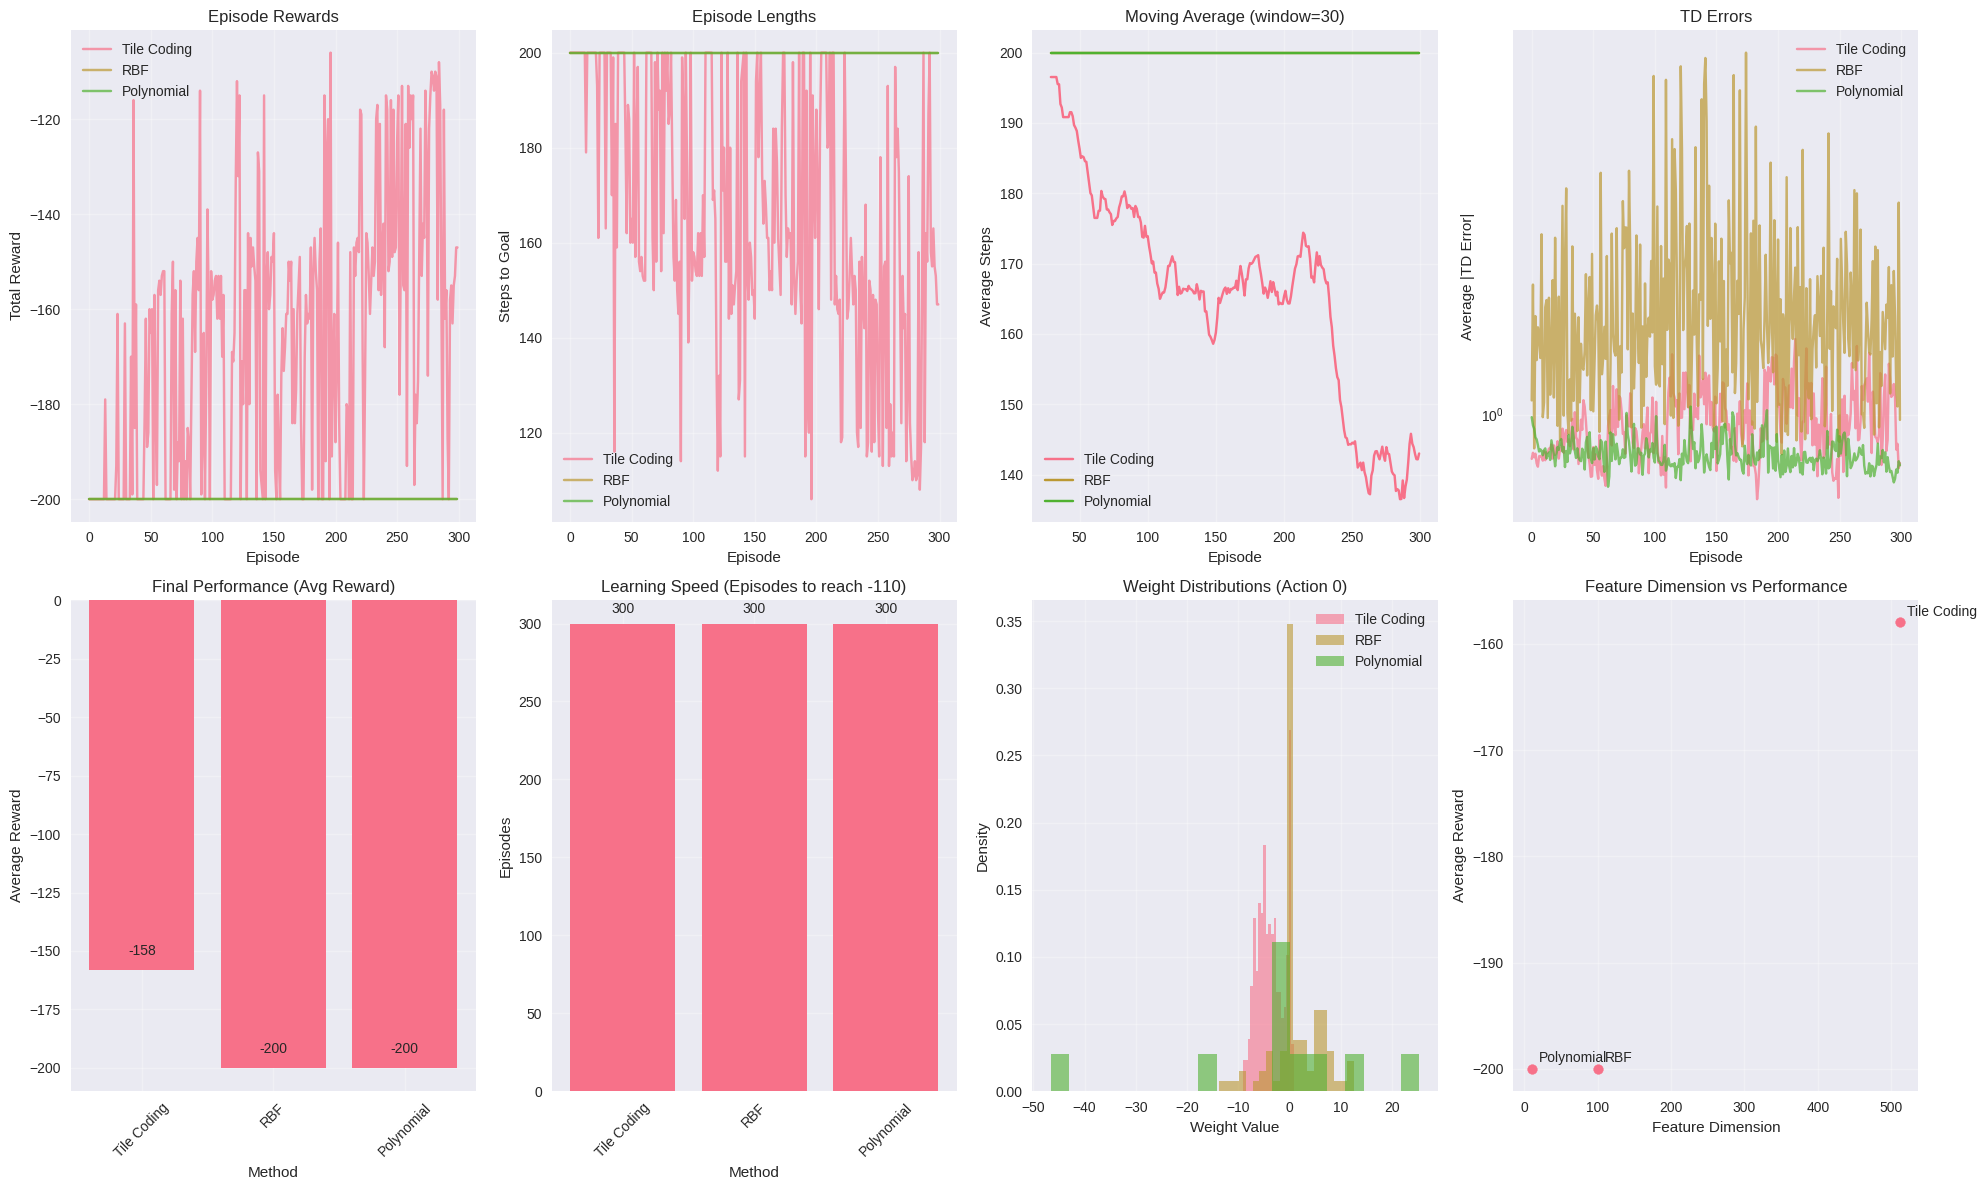


=== Performance Summary ===
Method          Feature Dim  Final Reward   Final Steps  Learning Speed 
---------------------------------------------------------------------------
Tile Coding     512          -158.0         158.0        300            
RBF             100          -200.0         200.0        300            
Polynomial      10           -200.0         200.0        300            


In [14]:
# Plot learning curves
plt.figure(figsize=(20, 12))

# Episode rewards
plt.subplot(2, 4, 1)
for name, agent in agents.items():
    plt.plot(agent.episode_rewards, label=name, alpha=0.7)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Episode lengths
plt.subplot(2, 4, 2)
for name, agent in agents.items():
    plt.plot(agent.episode_lengths, label=name, alpha=0.7)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

# Moving averages
plt.subplot(2, 4, 3)
window = 30
for name, agent in agents.items():
    if len(agent.episode_lengths) >= window:
        moving_avg = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(agent.episode_lengths)), moving_avg, label=name)
plt.title(f'Moving Average (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Steps')
plt.legend()
plt.grid(True, alpha=0.3)

# TD errors
plt.subplot(2, 4, 4)
for name, agent in agents.items():
    if hasattr(agent, 'td_errors') and len(agent.td_errors) > 0:
        plt.plot(agent.td_errors, label=name, alpha=0.7)
plt.title('TD Errors')
plt.xlabel('Episode')
plt.ylabel('Average |TD Error|')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Final performance comparison
plt.subplot(2, 4, 5)
final_rewards = []
final_steps = []
names = []

for name, agent in agents.items():
    try:
        avg_reward, avg_steps = agent.evaluate_policy(num_episodes=20)
        final_rewards.append(avg_reward)
        final_steps.append(avg_steps)
        names.append(name)
    except Exception as e:
        print(f"Evaluation error for {name}: {e}")
        # Use last few episode results as fallback
        if len(agent.episode_rewards) > 0:
            final_rewards.append(np.mean(agent.episode_rewards[-10:]))
            final_steps.append(np.mean(agent.episode_lengths[-10:]))
            names.append(name)

if names:  # Only plot if we have data
    x_pos = np.arange(len(names))
    bars = plt.bar(x_pos, final_rewards)
    plt.title('Final Performance (Avg Reward)')
    plt.xlabel('Method')
    plt.ylabel('Average Reward')
    plt.xticks(x_pos, names, rotation=45)

    for i, (bar, value) in enumerate(zip(bars, final_rewards)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f'{value:.0f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)

# Learning speed (episodes to solve)
plt.subplot(2, 4, 6)
if names:  # Only plot if we have data
    solve_threshold = -110  # Threshold for "solving" mountain car
    learning_speeds = []

    for name, agent in agents.items():
        if name in names:  # Only include successfully evaluated agents
            # Find first episode where moving average reward exceeds threshold
            window = 20
            if len(agent.episode_rewards) >= window:
                moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
                solved_episodes = np.where(moving_avg > solve_threshold)[0]
                if len(solved_episodes) > 0:
                    learning_speed = solved_episodes[0] + window - 1
                else:
                    learning_speed = len(agent.episode_rewards)
            else:
                learning_speed = len(agent.episode_rewards)

            learning_speeds.append(learning_speed)

    bars = plt.bar(x_pos, learning_speeds)
    plt.title(f'Learning Speed (Episodes to reach {solve_threshold})')
    plt.xlabel('Method')
    plt.ylabel('Episodes')
    plt.xticks(x_pos, names, rotation=45)

    for i, (bar, value) in enumerate(zip(bars, learning_speeds)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f'{value}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)

# Weight analysis
plt.subplot(2, 4, 7)
for name, agent in agents.items():
    try:
        # Plot weight distribution for first action (action 0)
        weights = agent.q_functions[0].get_weights()
        plt.hist(weights, bins=20, alpha=0.6, label=name, density=True)
    except Exception as e:
        print(f"Weight analysis error for {name}: {e}")

plt.title('Weight Distributions (Action 0)')
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature dimension vs performance
plt.subplot(2, 4, 8)
if names:  # Only plot if we have data
    feature_dims = []
    aligned_rewards = []

    for name in names:  # Use the same order as names list
        if name in feature_encoders:
            feature_dims.append(feature_encoders[name].get_feature_dim())
            # Find corresponding reward
            reward_idx = names.index(name)
            aligned_rewards.append(final_rewards[reward_idx])

    if len(feature_dims) == len(aligned_rewards) and len(feature_dims) > 0:
        plt.scatter(feature_dims, aligned_rewards)
        for i, name in enumerate(names):
            if i < len(feature_dims):
                plt.annotate(name, (feature_dims[i], aligned_rewards[i]),
                            xytext=(5, 5), textcoords='offset points')

        plt.title('Feature Dimension vs Performance')
        plt.xlabel('Feature Dimension')
        plt.ylabel('Average Reward')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Data alignment error\nSkipping this plot',
                ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Print summary with error handling
print("\n=== Performance Summary ===")
if names:
    print(f"{'Method':<15} {'Feature Dim':<12} {'Final Reward':<14} {'Final Steps':<12} {'Learning Speed':<15}")
    print("-" * 75)

    for i, name in enumerate(names):
        try:
            feature_dim = feature_encoders[name].get_feature_dim() if name in feature_encoders else "Unknown"
            final_reward = final_rewards[i] if i < len(final_rewards) else "N/A"
            final_step = final_steps[i] if i < len(final_steps) else "N/A"
            learning_speed = learning_speeds[i] if 'learning_speeds' in locals() and i < len(learning_speeds) else "N/A"

            print(f"{name:<15} {feature_dim:<12} {final_reward:<14.1f} {final_step:<12.1f} {learning_speed:<15}")
        except Exception as e:
            print(f"{name:<15} Error: {e}")
else:
    print("No agents were successfully trained and evaluated.")
    print("This may be due to environment or dependency issues.")
    print("Try running in Google Colab or check your local environment setup.")

## 7.5 Learned Value Function Visualization

Visualize the learned value functions for different feature representations.


Visualizing Tile Coding Value Function


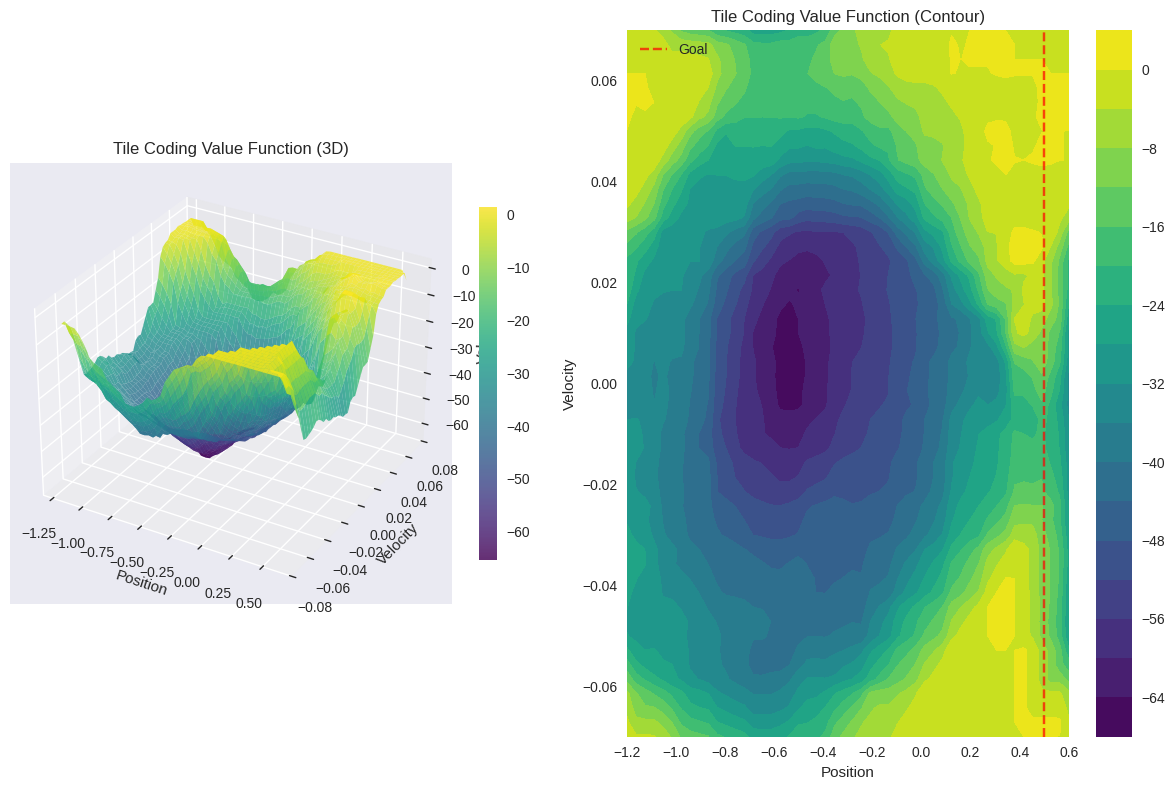


Visualizing RBF Value Function


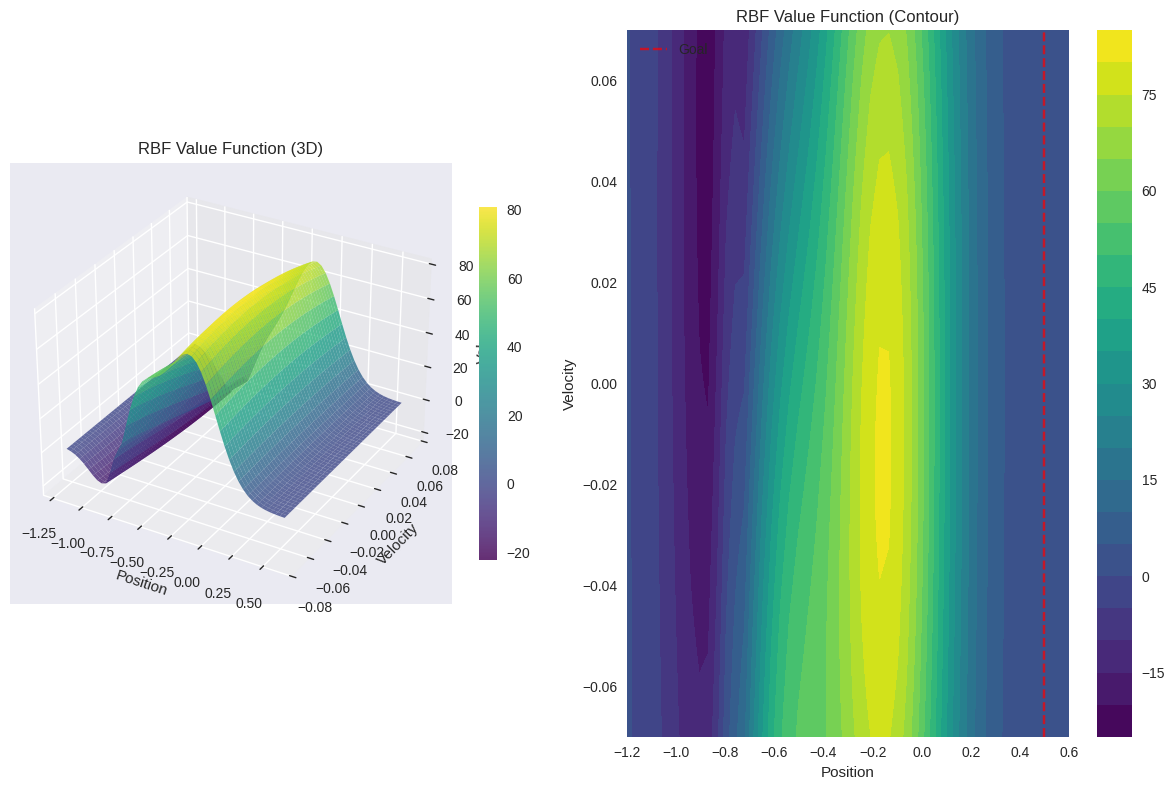


Visualizing Polynomial Value Function


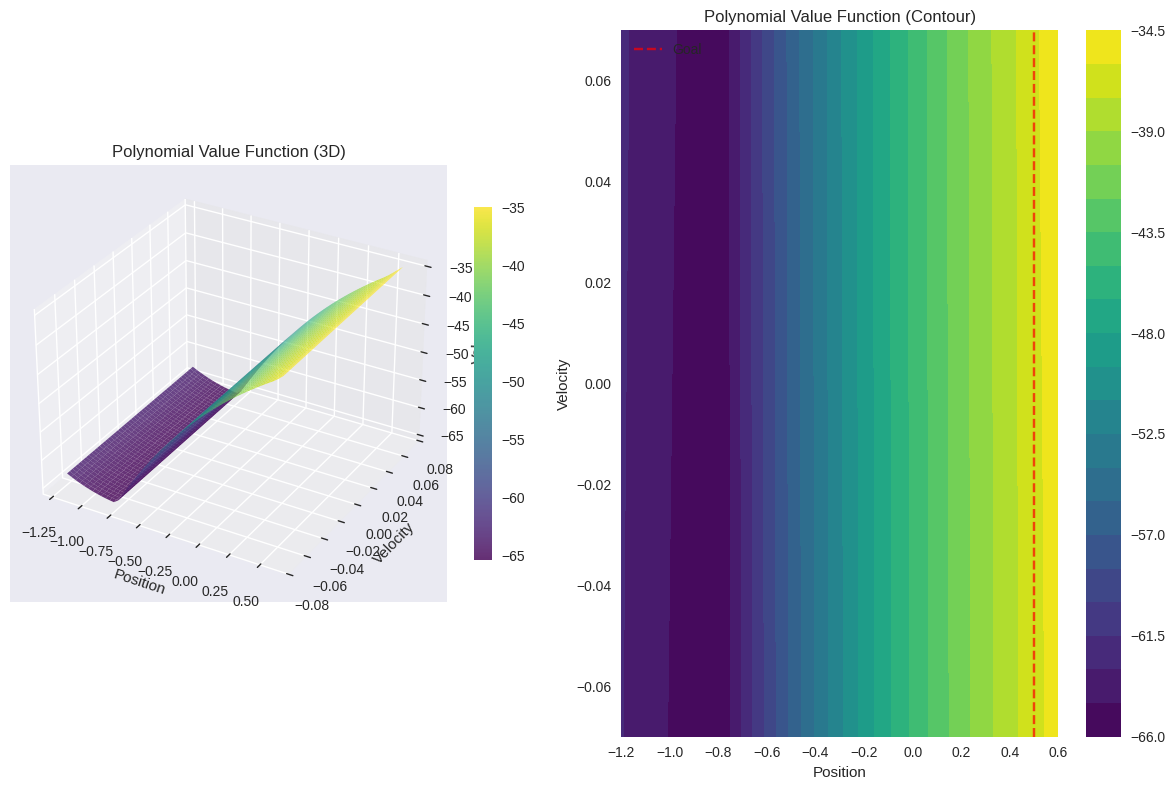

In [15]:
# Visualize learned value functions
for name, agent in agents.items():
    print(f"\nVisualizing {name} Value Function")
    env.visualize_value_function(agent.get_state_value, f"{name} Value Function")

## 7.6 Gradient TD Methods

Implement gradient TD methods that have better convergence guarantees.

Comparing TD vs GTD methods...

Training TD agent...


TD: 100%|██████████| 300/300 [00:18<00:00, 16.38it/s]


Final performance: -182.8 average reward

Training GTD agent...


GTD: 100%|██████████| 300/300 [00:26<00:00, 11.40it/s]


Final performance: -200.0 average reward


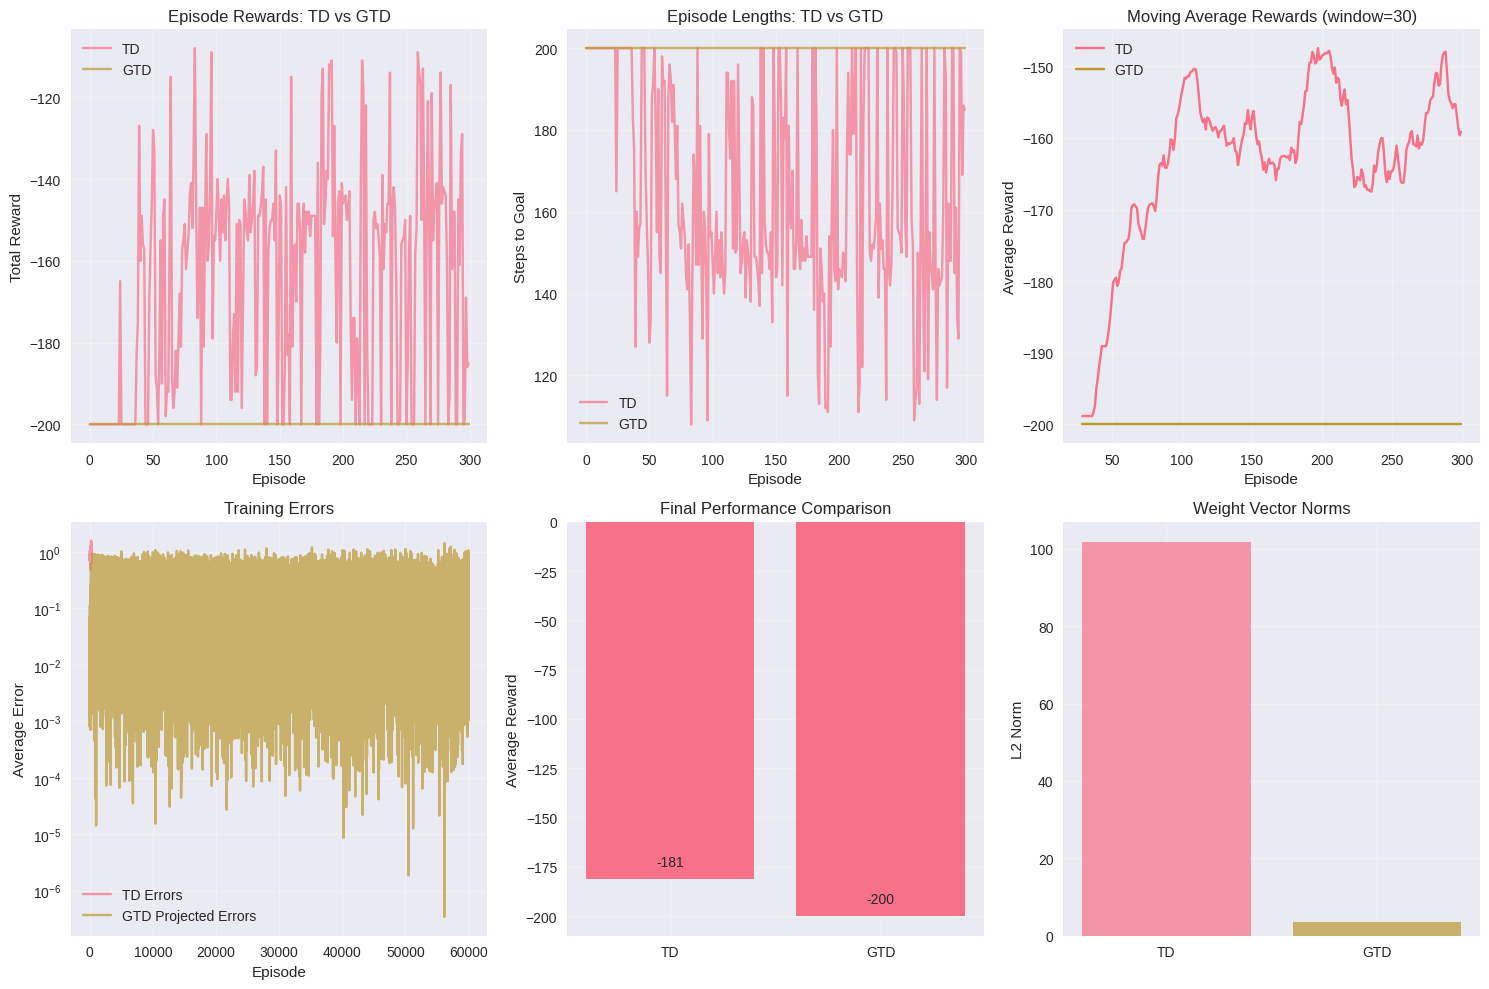


=== TD vs GTD Comparison ===
TD: Final performance = -180.3 average reward
GTD: Final performance = -200.0 average reward


In [16]:
class GradientTDAgent:
    """Gradient TD (GTD) agent with better convergence properties"""

    def __init__(self, env, feature_encoder, alpha=0.01, beta=0.01, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha  # Primary weights learning rate
        self.beta = beta    # Secondary weights learning rate
        self.gamma = gamma
        self.epsilon = epsilon

        self.feature_encoder = feature_encoder
        self.feature_dim = feature_encoder.get_feature_dim()

        # Initialize weights for each action
        self.w = {}  # Primary weights
        self.h = {}  # Secondary weights (for GTD)

        for action in env.get_valid_actions():
            self.w[action] = np.zeros(self.feature_dim, dtype=np.float32)
            self.h[action] = np.zeros(self.feature_dim, dtype=np.float32)

        self.episode_rewards = []
        self.episode_lengths = []
        self.projected_errors = []

    def predict_q(self, state, action):
        """Predict Q-value"""
        features = self.feature_encoder.encode(state)
        return np.dot(self.w[action], features)

    def epsilon_greedy_policy(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.get_valid_actions())
        else:
            actions = self.env.get_valid_actions()
            q_values = [self.predict_q(state, a) for a in actions]
            return actions[np.argmax(q_values)]

    def gtd_update(self, state, action, reward, next_state, done):
        """GTD(0) update"""
        phi = self.feature_encoder.encode(state)

        if done:
            phi_next = np.zeros_like(phi)
        else:
            # Use target policy (greedy) for next state
            next_actions = self.env.get_valid_actions()
            next_q_values = [self.predict_q(next_state, a) for a in next_actions]
            best_next_action = next_actions[np.argmax(next_q_values)]
            phi_next = self.feature_encoder.encode(next_state)

        # Current prediction
        v_current = np.dot(self.w[action], phi)

        # TD error
        if done:
            delta = reward - v_current
            phi_diff = phi
        else:
            v_next = np.dot(self.w[best_next_action], phi_next)
            delta = reward + self.gamma * v_next - v_current
            phi_diff = phi - self.gamma * phi_next

        # GTD updates
        # Update secondary weights
        self.h[action] += self.beta * (delta * phi - np.dot(phi, self.h[action]) * phi)

        # Update primary weights
        self.w[action] += self.alpha * (delta * phi - self.gamma * np.dot(phi_next, self.h[action]) * phi)

        # Track projected Bellman error
        projected_error = np.dot(phi_diff, self.h[action])
        self.projected_errors.append(abs(projected_error))

        return delta

    def train_episode(self, max_steps=500):
        """Train for one episode"""
        state = self.env.reset()
        episode_reward = 0
        steps = 0

        for step in range(max_steps):
            action = self.epsilon_greedy_policy(state)
            next_state, reward, done, _ = self.env.step(action)

            # GTD update
            self.gtd_update(state, action, reward, next_state, done)

            episode_reward += reward
            steps += 1

            if done:
                break

            state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)

        return episode_reward, steps

    def get_state_value(self, state):
        """Get state value (max Q-value)"""
        actions = self.env.get_valid_actions()
        q_values = [self.predict_q(state, a) for a in actions]
        return max(q_values)

    def evaluate_policy(self, num_episodes=10):
        """Evaluate current policy"""
        total_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset()
            episode_reward = 0

            for step in range(500):
                actions = self.env.get_valid_actions()
                q_values = [self.predict_q(state, a) for a in actions]
                action = actions[np.argmax(q_values)]

                state, reward, done, _ = self.env.step(action)
                episode_reward += reward

                if done:
                    break

            total_rewards.append(episode_reward)

        return np.mean(total_rewards)


# Re-define LinearTDAgent here to ensure it's available for comparison
class LinearTDAgent:
    """TD agent with linear function approximation"""

    def __init__(self, env, feature_encoder, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Create Q-function for each action
        self.q_functions = {}
        for action in env.get_valid_actions():
            self.q_functions[action] = LinearValueFunction(feature_encoder, alpha)

        self.episode_rewards = []
        self.episode_lengths = []
        self.td_errors = []

    def predict_q(self, state, action):
        """Predict Q-value for state-action pair"""
        return self.q_functions[action].predict(state)

    def epsilon_greedy_policy(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.get_valid_actions())
        else:
            actions = self.env.get_valid_actions()
            q_values = [self.predict_q(state, a) for a in actions]
            return actions[np.argmax(q_values)]

    def get_greedy_action(self, state):
        """Get greedy action (for evaluation)"""
        actions = self.env.get_valid_actions()
        q_values = [self.predict_q(state, a) for a in actions]
        return actions[np.argmax(q_values)]

    def train_episode(self, max_steps=500):
        """Train for one episode using Q-learning with function approximation"""
        state = self.env.reset()
        episode_reward = 0
        steps = 0
        episode_td_errors = []

        for step in range(max_steps):
            # Choose action
            action = self.epsilon_greedy_policy(state)

            # Take action
            next_state, reward, done, _ = self.env.step(action)
            episode_reward += reward
            steps += 1

            # Calculate target
            if done:
                target = reward
            else:
                next_actions = self.env.get_valid_actions()
                next_q_values = [self.predict_q(next_state, a) for a in next_actions]
                target = reward + self.gamma * max(next_q_values)

            # Update Q-function
            td_error = self.q_functions[action].update(state, target)
            episode_td_errors.append(abs(td_error))

            if done:
                break

            state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)
        self.td_errors.append(np.mean(episode_td_errors))

        return episode_reward, steps

    def evaluate_policy(self, num_episodes=10):
        """Evaluate current greedy policy"""
        total_rewards = []
        total_steps = []

        for _ in range(num_episodes):
            state = self.env.reset()
            episode_reward = 0
            steps = 0

            for step in range(500):
                action = self.get_greedy_action(state)
                state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                steps += 1

                if done:
                    break

            total_rewards.append(episode_reward)
            total_steps.append(steps)

        return np.mean(total_rewards), np.mean(total_steps)

    def get_state_value(self, state):
        """Get state value (max Q-value)"""
        actions = self.env.get_valid_actions()
        q_values = [self.predict_q(state, a) for a in actions]
        return max(q_values)


# Re-define LinearValueFunction to ensure it's available
class LinearValueFunction:
    """Linear value function approximation"""

    def __init__(self, feature_encoder, alpha=0.1):
        self.feature_encoder = feature_encoder
        self.alpha = alpha
        self.weights = np.zeros(feature_encoder.get_feature_dim(), dtype=np.float32)
        self.mse_history = []

    def predict(self, state):
        """Predict value for a state"""
        features = self.feature_encoder.encode(state)
        return np.dot(self.weights, features)

    def update(self, state, target):
        """Update weights using gradient descent"""
        features = self.feature_encoder.encode(state)
        prediction = np.dot(self.weights, features)
        error = target - prediction

        # Gradient descent update
        self.weights += self.alpha * error * features

        # Track MSE
        self.mse_history.append(error**2)

        return error

    def get_weights(self):
        return self.weights.copy()

    def set_weights(self, weights):
        self.weights = weights.copy()


# Compare standard TD with GTD
print("Comparing TD vs GTD methods...")

# Ensure we have a fresh environment and encoder
env = MountainCarFA()
encoder = TileCoding(num_tilings=8, tiles_per_dim=8)

# Standard TD agent
td_agent = LinearTDAgent(env, encoder, alpha=0.1, gamma=0.99, epsilon=0.1)

# GTD agent
gtd_agent = GradientTDAgent(env, encoder, alpha=0.01, beta=0.01, gamma=0.99, epsilon=0.1)

# Train both agents
training_episodes = 300
comparison_agents = {'TD': td_agent, 'GTD': gtd_agent}

for name, agent in comparison_agents.items():
    print(f"\nTraining {name} agent...")
    try:
        for episode in tqdm(range(training_episodes), desc=name):
            agent.train_episode()

            # Decay epsilon
            if episode % 50 == 0:
                agent.epsilon = max(0.01, agent.epsilon * 0.9)

        # Evaluate final performance
        if hasattr(agent, 'evaluate_policy'):
            final_performance = agent.evaluate_policy(num_episodes=20)
            if isinstance(final_performance, tuple):
                print(f"Final performance: {final_performance[0]:.1f} average reward")
            else:
                print(f"Final performance: {final_performance:.1f} average reward")
        else:
            print("No evaluation method available")

    except Exception as e:
        print(f"Error training {name} agent: {e}")
        print("Continuing with other agents...")

# Plot comparison
plt.figure(figsize=(15, 10))

# Learning curves
plt.subplot(2, 3, 1)
for name, agent in comparison_agents.items():
    if hasattr(agent, 'episode_rewards') and len(agent.episode_rewards) > 0:
        plt.plot(agent.episode_rewards, label=name, alpha=0.7)
plt.title('Episode Rewards: TD vs GTD')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
for name, agent in comparison_agents.items():
    if hasattr(agent, 'episode_lengths') and len(agent.episode_lengths) > 0:
        plt.plot(agent.episode_lengths, label=name, alpha=0.7)
plt.title('Episode Lengths: TD vs GTD')
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.legend()
plt.grid(True, alpha=0.3)

# Moving averages
plt.subplot(2, 3, 3)
window = 30
for name, agent in comparison_agents.items():
    if hasattr(agent, 'episode_rewards') and len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(agent.episode_rewards)), moving_avg, label=name)
plt.title(f'Moving Average Rewards (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Error analysis
plt.subplot(2, 3, 4)
if hasattr(td_agent, 'td_errors') and len(td_agent.td_errors) > 0:
    plt.plot(td_agent.td_errors, label='TD Errors', alpha=0.7)
if hasattr(gtd_agent, 'projected_errors') and len(gtd_agent.projected_errors) > 0:
    plt.plot(gtd_agent.projected_errors, label='GTD Projected Errors', alpha=0.7)
plt.title('Training Errors')
plt.xlabel('Episode')
plt.ylabel('Average Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Final performance comparison
plt.subplot(2, 3, 5)
final_rewards = []
method_names = []
for name, agent in comparison_agents.items():
    try:
        if hasattr(agent, 'evaluate_policy'):
            perf = agent.evaluate_policy(20)
            if isinstance(perf, tuple):
                final_rewards.append(perf[0])
            else:
                final_rewards.append(perf)
        else:
            # Fallback to recent episode performance
            final_rewards.append(np.mean(agent.episode_rewards[-20:]))
        method_names.append(name)
    except Exception as e:
        print(f"Performance evaluation error for {name}: {e}")

if method_names:
    bars = plt.bar(method_names, final_rewards)
    plt.title('Final Performance Comparison')
    plt.ylabel('Average Reward')
    for bar, value in zip(bars, final_rewards):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f'{value:.0f}', ha='center', va='bottom')
    plt.grid(True, alpha=0.3)

# Weight magnitude comparison
plt.subplot(2, 3, 6)
for name, agent in comparison_agents.items():
    try:
        if hasattr(agent, 'q_functions') and 0 in agent.q_functions:
            weights = agent.q_functions[0].get_weights()
        elif hasattr(agent, 'w') and 0 in agent.w:
            weights = agent.w[0]
        else:
            continue

        weight_norms = [np.linalg.norm(weights)]
        plt.bar([name], weight_norms, alpha=0.7)
    except Exception as e:
        print(f"Weight analysis error for {name}: {e}")

plt.title('Weight Vector Norms')
plt.ylabel('L2 Norm')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== TD vs GTD Comparison ===")
for name, agent in comparison_agents.items():
    try:
        if hasattr(agent, 'evaluate_policy'):
            final_perf = agent.evaluate_policy(20)
            if isinstance(final_perf, tuple):
                print(f"{name}: Final performance = {final_perf[0]:.1f} average reward")
            else:
                print(f"{name}: Final performance = {final_perf:.1f} average reward")
        else:
            recent_perf = np.mean(agent.episode_rewards[-20:]) if len(agent.episode_rewards) >= 20 else "N/A"
            print(f"{name}: Recent performance = {recent_perf:.1f} average reward")
    except Exception as e:
        print(f"{name}: Performance evaluation failed - {e}")

## 7.7 Convergence Analysis

Analyze the convergence properties of different function approximation methods.

=== Convergence Analysis ===
Method               Final Mean   Final Std   Stability   Learning Speed 
---------------------------------------------------------------------------
Tile Coding          -143.8       27.8        0.193       300            
RBF                  -200.0       0.0         0.000       300            
Polynomial           -200.0       0.0         0.000       300            
TD                   -159.0       29.4        0.185       300            
GTD                  -200.0       0.0         0.000       300            

Best overall method: Tile Coding (composite score: 0.600)


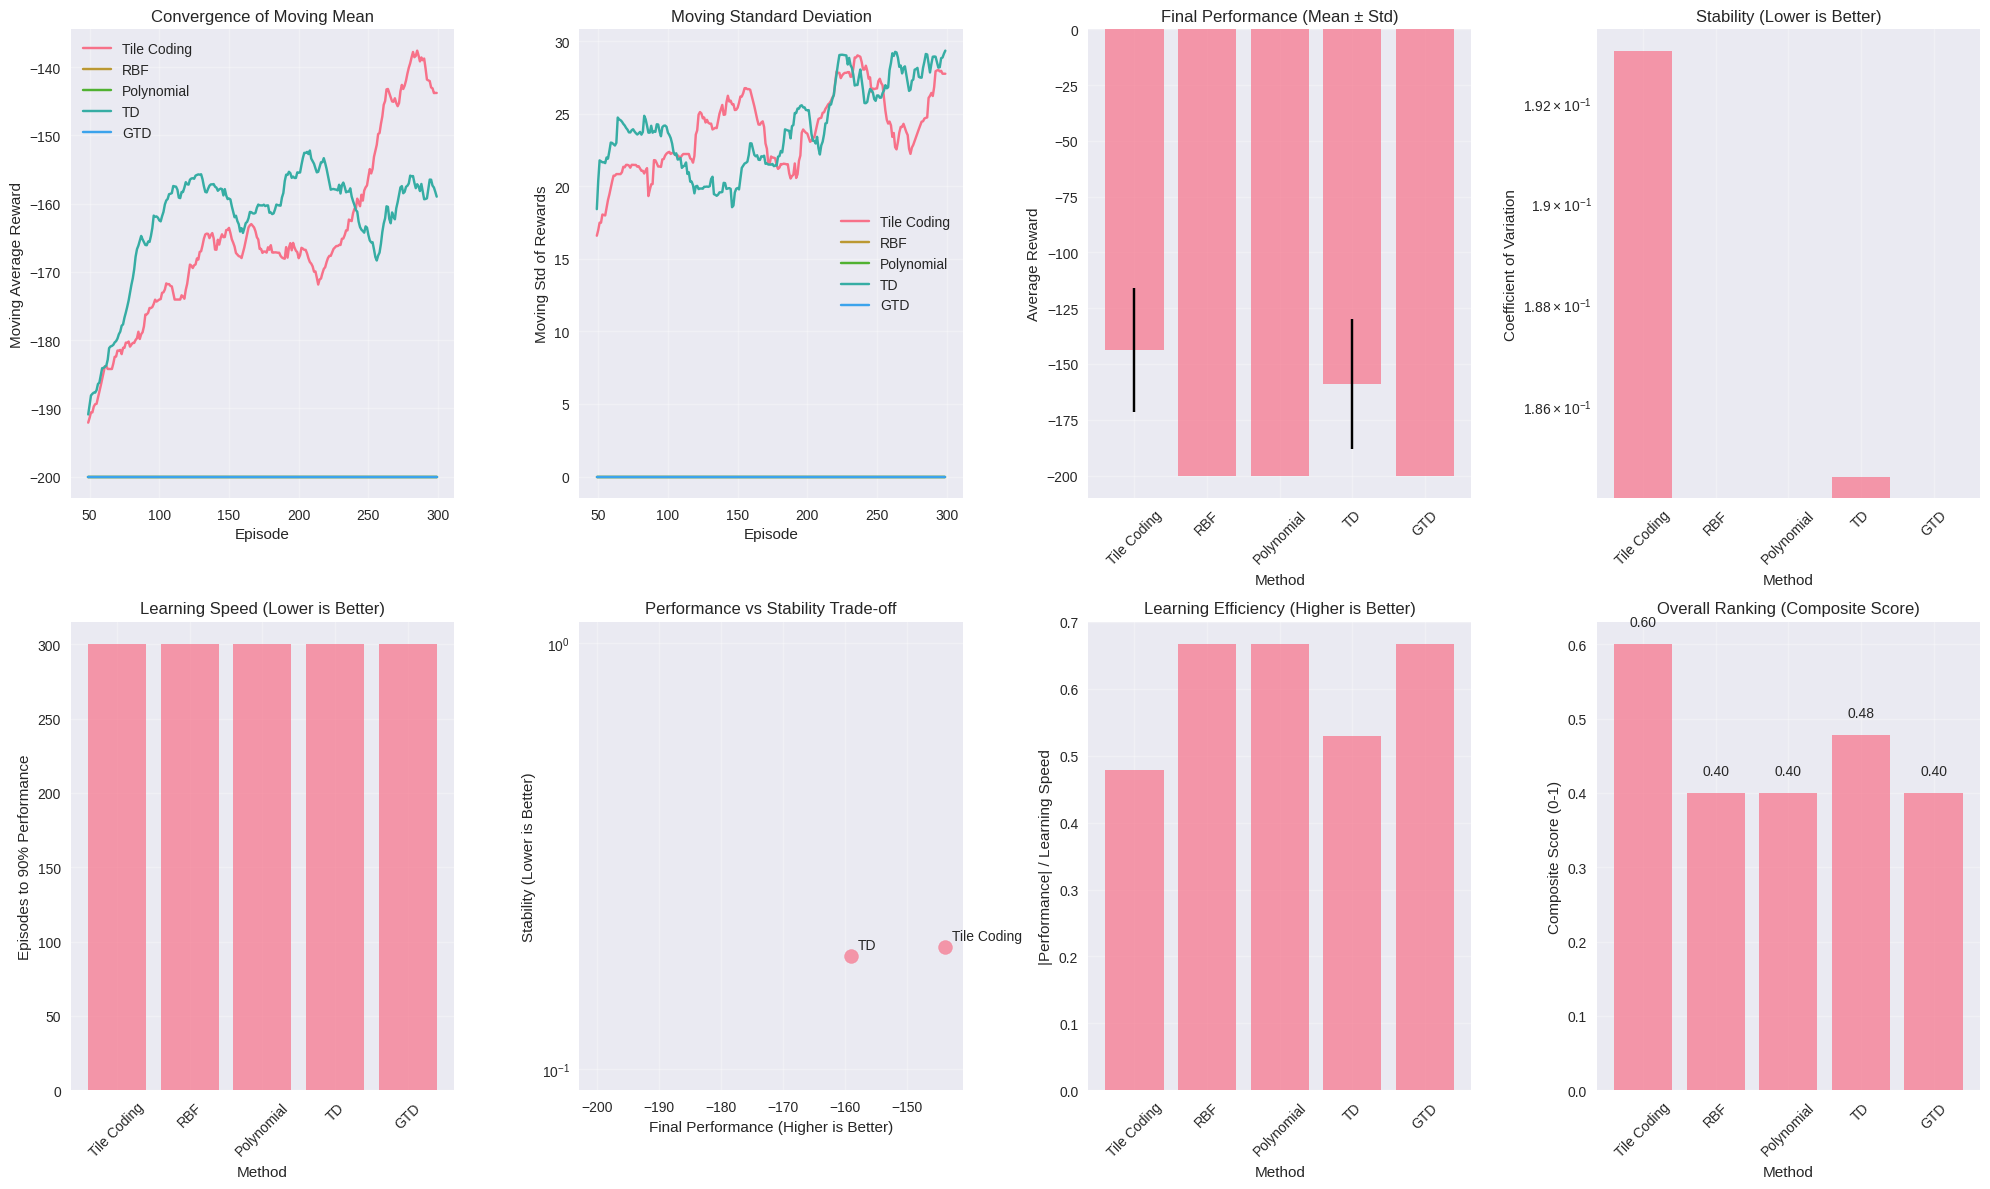

In [17]:
def analyze_convergence(agent, window=50):
    """Analyze convergence properties of an agent"""
    if not hasattr(agent, 'episode_rewards') or len(agent.episode_rewards) == 0:
        return None

    rewards = np.array(agent.episode_rewards)
    lengths = np.array(agent.episode_lengths) if hasattr(agent, 'episode_lengths') else rewards

    # Calculate moving statistics
    if len(rewards) >= window:
        moving_mean = np.convolve(rewards, np.ones(window)/window, mode='valid')
        moving_std = np.array([np.std(rewards[i:i+window]) for i in range(len(rewards)-window+1)])

        # Convergence metrics
        final_mean = np.mean(rewards[-window:])
        final_std = np.std(rewards[-window:])

        # Stability (coefficient of variation in final episodes)
        stability = final_std / abs(final_mean) if final_mean != 0 else float('inf')

        # Learning speed (episodes to reach 90% of final performance)
        target = 0.9 * final_mean
        reached_target = np.where(moving_mean >= target)[0]
        learning_speed = reached_target[0] + window - 1 if len(reached_target) > 0 else len(rewards)

        return {
            'final_mean': final_mean,
            'final_std': final_std,
            'stability': stability,
            'learning_speed': learning_speed,
            'moving_mean': moving_mean,
            'moving_std': moving_std
        }
    else:
        return None

# Analyze all agents with better error handling
print("=== Convergence Analysis ===")

convergence_data = {}
all_agents_analysis = {**agents}

# Add comparison agents if they exist
try:
    if 'comparison_agents' in locals():
        all_agents_analysis.update(comparison_agents)
except:
    pass

successful_analyses = []
for name, agent in all_agents_analysis.items():
    try:
        analysis = analyze_convergence(agent)
        if analysis:
            convergence_data[name] = analysis
            successful_analyses.append((name, analysis))
    except Exception as e:
        print(f"Analysis error for {name}: {e}")

if successful_analyses:
    print(f"{'Method':<20} {'Final Mean':<12} {'Final Std':<11} {'Stability':<11} {'Learning Speed':<15}")
    print("-" * 75)

    for name, analysis in successful_analyses:
        print(f"{name:<20} {analysis['final_mean']:<12.1f} {analysis['final_std']:<11.1f} {analysis['stability']:<11.3f} {analysis['learning_speed']:<15}")

    # Plot convergence analysis only if we have data
    plt.figure(figsize=(20, 12))

    # Moving means
    plt.subplot(2, 4, 1)
    for name, data in convergence_data.items():
        window = 50
        x_range = range(window-1, window-1+len(data['moving_mean']))
        plt.plot(x_range, data['moving_mean'], label=name)
    plt.title('Convergence of Moving Mean')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Moving standard deviations
    plt.subplot(2, 4, 2)
    for name, data in convergence_data.items():
        window = 50
        x_range = range(window-1, window-1+len(data['moving_std']))
        plt.plot(x_range, data['moving_std'], label=name)
    plt.title('Moving Standard Deviation')
    plt.xlabel('Episode')
    plt.ylabel('Moving Std of Rewards')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Final performance
    plt.subplot(2, 4, 3)
    names = list(convergence_data.keys())
    final_means = [convergence_data[name]['final_mean'] for name in names]
    final_stds = [convergence_data[name]['final_std'] for name in names]

    x_pos = np.arange(len(names))
    plt.bar(x_pos, final_means, yerr=final_stds, capsize=5, alpha=0.7)
    plt.title('Final Performance (Mean ± Std)')
    plt.xlabel('Method')
    plt.ylabel('Average Reward')
    plt.xticks(x_pos, names, rotation=45)
    plt.grid(True, alpha=0.3)

    # Stability comparison
    plt.subplot(2, 4, 4)
    stabilities = [convergence_data[name]['stability'] for name in names]
    bars = plt.bar(x_pos, stabilities, alpha=0.7)
    plt.title('Stability (Lower is Better)')
    plt.xlabel('Method')
    plt.ylabel('Coefficient of Variation')
    plt.xticks(x_pos, names, rotation=45)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    # Learning speed
    plt.subplot(2, 4, 5)
    learning_speeds = [convergence_data[name]['learning_speed'] for name in names]
    bars = plt.bar(x_pos, learning_speeds, alpha=0.7)
    plt.title('Learning Speed (Lower is Better)')
    plt.xlabel('Method')
    plt.ylabel('Episodes to 90% Performance')
    plt.xticks(x_pos, names, rotation=45)
    plt.grid(True, alpha=0.3)

    # Performance vs stability trade-off
    plt.subplot(2, 4, 6)
    plt.scatter(final_means, stabilities, s=100, alpha=0.7)
    for i, name in enumerate(names):
        plt.annotate(name, (final_means[i], stabilities[i]),
                    xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Final Performance (Higher is Better)')
    plt.ylabel('Stability (Lower is Better)')
    plt.title('Performance vs Stability Trade-off')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    # Learning efficiency (performance / learning speed)
    plt.subplot(2, 4, 7)
    efficiencies = [abs(final_means[i]) / max(learning_speeds[i], 1) for i in range(len(names))]
    bars = plt.bar(x_pos, efficiencies, alpha=0.7)
    plt.title('Learning Efficiency (Higher is Better)')
    plt.xlabel('Method')
    plt.ylabel('|Performance| / Learning Speed')
    plt.xticks(x_pos, names, rotation=45)
    plt.grid(True, alpha=0.3)

    # Overall ranking
    plt.subplot(2, 4, 8)
    if len(final_means) > 1:  # Only compute ranking if we have multiple methods
        # Normalize metrics (0-1 scale) and compute composite score
        min_perf, max_perf = min(final_means), max(final_means)
        norm_performance = [(p - min_perf) / (max_perf - min_perf) if max_perf > min_perf else 0.5 for p in final_means]

        min_stab, max_stab = min(stabilities), max(stabilities)
        norm_stability = [(max_stab - s) / (max_stab - min_stab) if max_stab > min_stab else 0.5 for s in stabilities] # Inverted

        min_speed, max_speed = min(learning_speeds), max(learning_speeds)
        norm_speed = [(max_speed - s) / (max_speed - min_speed) if max_speed > min_speed else 0.5 for s in learning_speeds] # Inverted

        # Weighted composite score
        composite_scores = [0.5*p + 0.3*st + 0.2*sp for p, st, sp in zip(norm_performance, norm_stability, norm_speed)]

        bars = plt.bar(x_pos, composite_scores, alpha=0.7)
        plt.title('Overall Ranking (Composite Score)')
        plt.xlabel('Method')
        plt.ylabel('Composite Score (0-1)')
        plt.xticks(x_pos, names, rotation=45)
        plt.grid(True, alpha=0.3)

        for i, score in enumerate(composite_scores):
            plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

        # Find best method
        best_idx = np.argmax(composite_scores)
        print(f"\nBest overall method: {names[best_idx]} (composite score: {composite_scores[best_idx]:.3f})")
    else:
        plt.text(0.5, 0.5, 'Need multiple methods\nfor ranking comparison',
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

else:
    print("No agents available for convergence analysis.")
    print("This may be due to training failures or environment issues.")
    print("Ensure that at least one agent trained successfully before running this analysis.")

## 🎯 Chapter 7 Summary

This notebook demonstrated linear function approximation methods for reinforcement learning:

### Key Insights:

1. **Feature Representation Matters**:
   - Tile coding: Good for local generalization
   - RBF features: Smooth interpolation
   - Polynomial features: Global patterns but may overfit

2. **Algorithm Selection**:
   - Standard TD: Simple and often effective
   - GTD: Better convergence guarantees, especially off-policy
   - Trade-offs between performance, stability, and learning speed

3. **Convergence Properties**:
   - Linear function approximation provides convergence guarantees
   - Feature engineering is crucial for good performance
   - GTD methods provide more stable learning

### Practical Guidelines:

- **Choose features based on problem structure**
- **Tile coding for local features, RBF for smooth functions**
- **Monitor both performance and stability**
- **Consider GTD for off-policy learning**

### Next Steps:
- Chapter 8: Deep Reinforcement Learning
- Experiment with different feature combinations
- Try on other continuous control problems

---
*This notebook is part of the Reinforcement Learning for Engineer-Mathematicians textbook.*